# Estimating Aboveground Biomass in a Protected Area using GEDI L4A dataset

## Overview
This tutorial will demonstrate how to directly access and subset the GEDI L4A dataset using [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/) and compute summary of aboveground biomass for a protected area in Mexico. The Harmony API allows seamless access and production of  analysis-ready Earth observation data across different DAACs, by enabling cloud-based spatial, temporal, and variable subsetting and data conversions.  The GEDI L4A dataset is available from the Harmony API. 

## Learning Objectives
- Use [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/) to retrieve the GEDI L4A dataset. The Harmony API allows access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data file.
- Compute summaries of AGBD across various plant functional types (PFTs)


## Requirements
### 1. Compute environment
This notebook can be run in any personal computing environment (e.g., desktop/laptops), on-premise solution (e.g., High-Performance Computing), or on the Cloud (e.g., Amazon Web Service).

### 2. Earthdata Login
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

### 3. Additional Requirements
While NASA's Harmony services are available directly through RESTful API, we will use [Harmony-Py](https://github.com/nasa/harmony-py) Python library for this tutorial. Harmony-Py provides a friendly interface for integrating with NASA's Harmony Services. In addition to Harmony-Py, this tutorial requires the following Python modules installed in your system: `earthaccess`, `h5py`, `requests`, `datetime`, `pandas`, `geopandas`, `contextily`. Requirements are also in [requirements.txt](requirements.txt). To install the necessary Python modules, you can copy the requirements.txt from this repository and run:

```bash
pip install --user h5py, requests, datetime, pandas, geopandas, contextily
```
## Import Modules

In [1]:
# import python modules
import h5py
import requests as re
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
from harmony import BBox, Client, Collection, Environment, Request
import seaborn as sns
sns.set(style='whitegrid')
import warnings
warnings.filterwarnings('ignore')

NASA Harmony API requires [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/). You can use the [earthaccess](https://nsidc.github.io/earthaccess/) Python library to set up authetincation. Alternatively, you can also login to harmony_client directly by passing EDL authentication as the following in the Jupyter Notebook itself:

```
harmony_client = Client(auth=("your EDL username", "your EDL password"))
```

First, we create a Harmony Client object. If you are passing the EDL authentication, please do as shown above with `auth` parameter.

In [2]:
harmony_client = Client()

Now let's retrieve the `Concept ID` of the GEDI L4A dataset. The `Concept ID` is NASA Earthdata's unique ID for its dataset. 

In [3]:
# GEDI L4A DOI 
doi = '10.3334/ORNLDAAC/2056'

# CMR API base url
doisearch=f'https://cmr.earthdata.nasa.gov/search/collections.json?doi={doi}' 
concept_id = re.get(doisearch).json()['feed']['entry'][0]['id']
concept_id

'C2237824918-ORNL_CLOUD'

Let's create a Harmony Collection object with the concept_id retrieved above. We will also define the GEDI L4A variables of interest and temporal range.

In [4]:
collection = Collection(id=concept_id)
# gedi beams
beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101','BEAM0110','BEAM1000','BEAM1011']
# gedi variables
vars = ['agbd', 'l4_quality_flag', 'elev_lowestmode', 'land_cover_data/pft_class']
# combine variables and beams
variables = [f'/{b}/{v}' for b in beams for v in vars]
temporal_range = {'start': datetime(2022, 1, 1), 
                  'stop': datetime(2022, 12, 31)}

We will use the spatial extent of a [La Primavera Biosphere Reserve](https://en.wikipedia.org/wiki/La_Primavera_Biosphere_Reserve) provided as a GeoJSON file at `bosque_primavera.json`. Let's open this file and compute its bound.

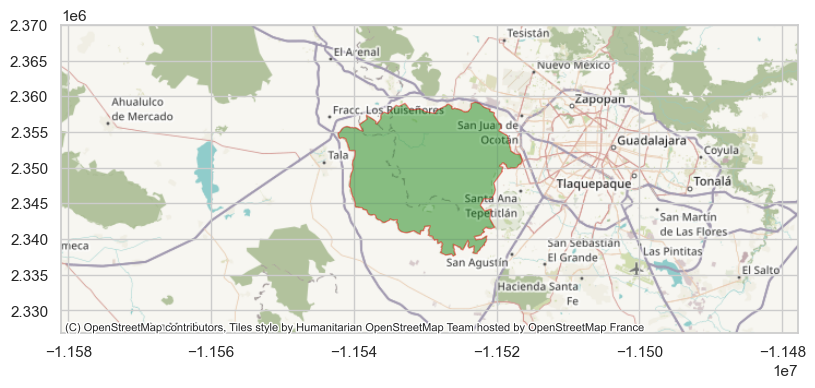

In [5]:
salix = gpd.read_file("bosque_primavera.json") 
b = salix.total_bounds
# bounding box for Harmony
bounding_box = BBox(w=b[0], s=b[1], e=b[2], n=b[3])
# map of Salix plots
ax=salix.to_crs(epsg=3857).plot(figsize=(10, 4), alpha=0.4, color='green', edgecolor='red')
plt.margins(y=0.5, x=1.5)
ctx.add_basemap(ax)

Now we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. We will use the `download_all` method, which uses a multithreaded downloader and returns a [concurrent future](https://docs.python.org/3/library/concurrent.futures.html). Futures are asynchronous and let us use the downloaded file as soon as the download is complete while other files are still being downloaded. 

In [6]:
request = Request(collection=collection, 
                  variables=variables, 
                  temporal=temporal_range,
                  spatial=bounding_box,
                  ignore_errors=True)

# submit harmony request, will return job id
subset_job_id = harmony_client.submit(request)

print(f'Processing job: {subset_job_id}')

print(f'Waiting for the job to finish')
results = harmony_client.result_json(subset_job_id, show_progress=True)

print(f'Downloading subset files...')
futures = harmony_client.download_all(subset_job_id, overwrite=False)
for f in futures:
    # all subsetted files have this suffix
    if f.result().endswith('subsetted.h5'):
        print(f'Downloaded: {f.result()}')
            
print(f'Done downloading files.')

Processing job: b22f03bd-8201-47b8-9cf6-ef43dc87eb60
Waiting for the job to finish


 [ Processing: 100% ] |###################################################| [|]


GEDI04_A_2022038005838_O17868_03_T07458_02_003_01_V002_subsetted.h5
Downloaded: GEDI04_A_2022038005838_O17868_03_T07458_02_003_01_V002_subsetted.h5
GEDI04_A_2022006042512_O17374_02_T08156_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2022006042512_O17374_02_T08156_02_002_02_V002_subsetted.h5
GEDI04_A_2022088050647_O18646_03_T03189_02_003_01_V002_subsetted.h5
Downloaded: GEDI04_A_2022088050647_O18646_03_T03189_02_003_01_V002_subsetted.h5
GEDI04_A_2022316014330_O22180_02_T08156_02_003_01_V002_subsetted.h5
Downloaded: GEDI04_A_2022316014330_O22180_02_T08156_02_003_01_V002_subsetted.h5
GEDI04_A_2022244150958_O21072_03_T00496_02_003_01_V002_subsetted.h5
Downloaded: GEDI04_A_2022244150958_O21072_03_T00496_02_003_01_V002_subsetted.h5
GEDI04_A_2022129034426_O19281_02_T02464_02_003_01_V002_subsetted.h5
Downloaded: GEDI04_A_2022129034426_O19281_02_T02464_02_003_01_V002_subsetted.h5
GEDI04_A_2022201225441_O20410_02_T01041_02_003_02_V002_subsetted.h5
Downloaded: GEDI04_A_2022201225441_O20410_02

All the subsetted files are saved as `_subsetted.h5`. Let's read these `h5` files into a pandas dataframe.

In [10]:
subset_df = pd.DataFrame()
for subfile in glob('*_subsetted.h5'):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            col_names = []
            col_val = []
            # read all variables
            for key, value in beam.items():
                # check if the item is a group
                if isinstance(value, h5py.Group):
                    # looping through subgroups
                    for key2, value2 in value.items():
                        col_names.append(key2)
                        col_val.append(value2[:].tolist())
                else:
                    col_names.append(key)
                    col_val.append(value[:].tolist())

        # Appending to the subset_df dataframe
        beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names)
        subset_df = pd.concat([subset_df, beam_df])
    hf_in.close()
# print head of dataframe
subset_df.head()

,agbd,delta_time,elev_lowestmode,lat_lowestmode_a1,lon_lowestmode_a1,shot_number,l4_quality_flag,pft_class,shot_number,lat_lowestmode,lon_lowestmode,shot_number
0,17.204693,1.266801e+08,1685.324097,20.544943,-103.506392,173740000200217668,0,6,173740000200217668,20.544941,-103.506393,173740000200217668
1,80.229103,1.266801e+08,1654.737671,20.545329,-103.506056,173740000200217669,0,8,173740000200217669,20.545329,-103.506056,173740000200217669
2,98.612915,1.266801e+08,1627.466553,20.545720,-103.505717,173740000200217670,0,8,173740000200217670,20.545718,-103.505718,173740000200217670
3,12.086709,1.266801e+08,1624.882080,20.546119,-103.505376,173740000200217671,0,8,173740000200217671,20.546119,-103.505376,173740000200217671
4,11.747370,1.266801e+08,1624.152100,20.546522,-103.505034,173740000200217672,0,8,173740000200217672,20.546522,-103.505034,173740000200217672


We can now quality filter the dataset and only retrieve the good quality shots for trees and shrub cover plant functional types (PFTs). 

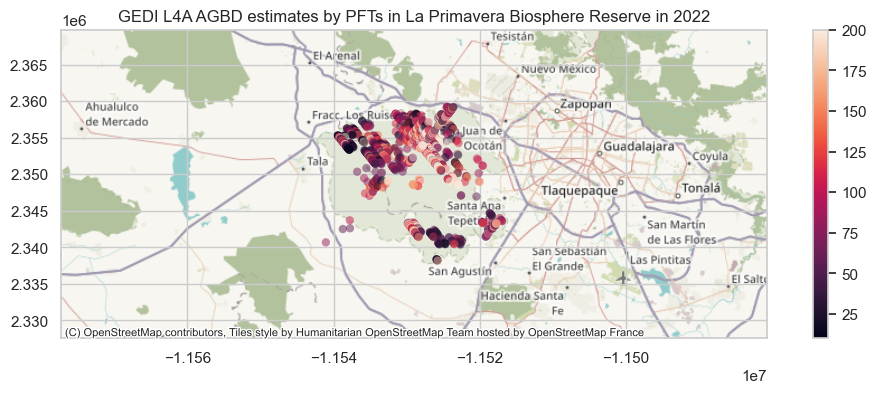

In [11]:
# MCD12Q1 PFT types
pft_legend = {0 : 'Water Bodies', 1: 'Evergreen Needleleaf Trees', 2: 'Evergreen Broadleaf Trees', 
              3: 'Deciduous Needleleaf Trees',  4: 'Deciduous Broadleaf Trees', 5: 'Shrub', 6: 'Grass',
              7: 'Cereal Croplands', 8: 'Broadleaf Croplands', 9: 'Urban and Built-up Lands', 
              10: 'Permanent Snow and Ice', 11: 'Barren', 255: 'Unclassified'}
# creating mask with good quality shots and trees/shrubs pft class
mask = (subset_df['l4_quality_flag']==1) & (subset_df['pft_class'] <= 5 )
# create geopandas dtframe
gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
gdf.crs="EPSG:4326"
# ax1=gdf_epsg3857.plot(color='white', alpha=0.3, linewidth=5, )
ax1= gdf.to_crs(epsg=3857)[mask].plot(column='agbd', alpha=0.5, vmax=200, 
                                                      linewidth=0, legend=True, figsize=(12, 4))
plt.margins(y=0.5, x=1.5)
plt.title('GEDI L4A AGBD estimates by PFTs in La Primavera Biosphere Reserve in 2022')
ctx.add_basemap(ax1)

We can now plot the distribution of the AGBD by plant functional types (PFTs) for the good quality shots.

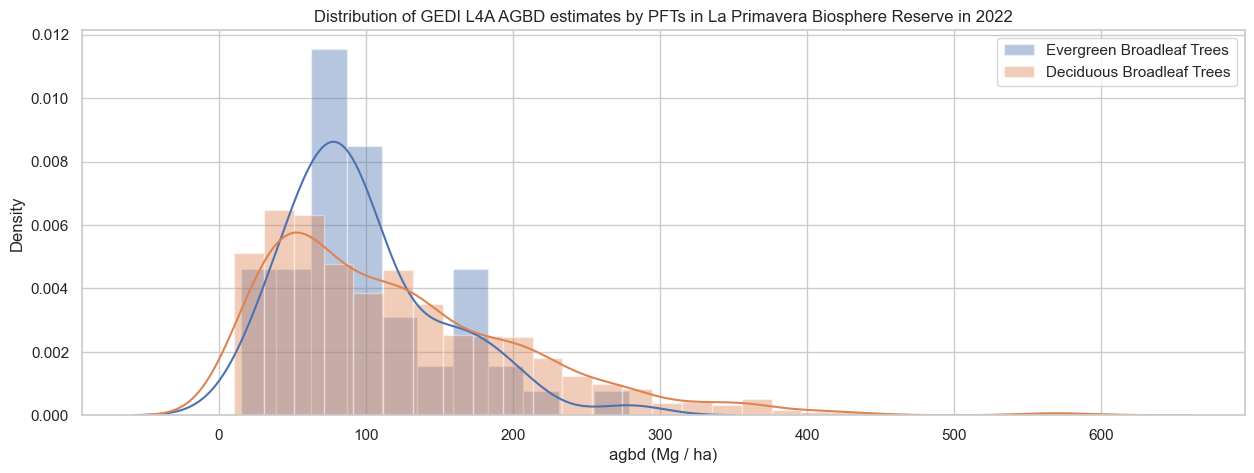

In [12]:
plt.figure(figsize=(15,5))
ax = gdf[mask].groupby('pft_class')['agbd'].\
            apply(lambda x: sns.distplot(x, label = pft_legend[x.name], hist=True))
plt.xlabel('agbd (Mg / ha)')
plt.title('Distribution of GEDI L4A AGBD estimates by PFTs in La Primavera Biosphere Reserve in 2022')
plt.legend()
plt.show()